In [1]:
import cdsapi
import netCDF4
from netCDF4 import Dataset
import pygrib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import zipfile
import os
import gdown

## Countries

In [2]:
countries_zip_url = "https://drive.google.com/uc?id=1UQzdO7suT0BnwKBeNybMG97vM9GIDogA"
countries_zip_file_path = "../allCountries.zip"

# Download the ZIP file if it doesn't exist; otherwise, proceed to read the TXT file.
if not os.path.exists(countries_zip_file_path):
    gdown.download(countries_zip_url, countries_zip_file_path, quiet=False)

with zipfile.ZipFile(countries_zip_file_path) as z:
    countries_txt_filename = "allCountries.txt"

    with z.open(countries_txt_filename) as txt_file:
        countries_df = pd.read_csv(txt_file, sep="\t", header=None)

print(f"\nshape: {countries_df.shape}")
countries_df.head()

/var/folders/9m/ym86jvl93wq3tx6ssy8ql7kh0000gn/T/ipykernel_33757/3175955485.py:12: DtypeWarning: Columns (9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  countries_df = pd.read_csv(txt_file, sep="\t", header=None)



shape: (12950185, 19)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2994701,Roc Meler,Roc Meler,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74180,T,PK,AD,"AD,FR",02,NaN,NaN,NaN,0,2811.0,2348,Europe/Andorra,2023-10-03
1,3017832,Pic de les Abelletes,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,T,PK,AD,FR,A9,66,663.0,66146.0,0,NaN,2411,Europe/Andorra,2014-11-05
2,3017833,Estany de les Abelletes,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,H,LK,AD,FR,A9,NaN,NaN,NaN,0,NaN,2260,Europe/Andorra,2014-11-05
3,3023203,Port Vieux de la Coume d’Ose,Port Vieux de la Coume d'Ose,"Port Vieux de Coume d'Ose,Port Vieux de Coume ...",42.62568,1.61823,T,PASS,AD,NaN,00,NaN,NaN,NaN,0,NaN,2687,Europe/Andorra,2014-11-05
4,3029315,Port de la Cabanette,Port de la Cabanette,"Port de la Cabanette,Porteille de la Cabanette",42.60000,1.73333,T,PASS,AD,"AD,FR",B3,09,91.0,9139.0,0,NaN,2379,Europe/Andorra,2014-11-05


## EUI

In [3]:
eui_url = "https://drive.google.com/uc?id=12qGq_DLefI1RihIF_RKQUyJtm480-xRC"
eui_df = pd.read_csv(eui_url)

print(f"shape: {eui_df.shape}")
eui_df.head()

shape: (482, 5)


,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year)
0,Nha Trang,1572151,Vietnam,59.096065,112.778867
1,Aberdeen,2657832,United Kingdom,231.302877,259.832393
2,Abidjan,2293538,Cote d'Ivoire,73.830819,105.622137
3,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457
4,Abuja,2352778,Nigeria,63.955819,103.009079


## Temperature

### Note: The following tempreture data is downloaded via API. I chooes the data as 2m temperature, 2023, April, 22, 3:00, NetCDF.

### Here is the API: 
```
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': '2023',
        'month': '04',
        'day': '22',
        'time': '03:00',
    },
    'download.nc')
```

In [4]:
''' 
c = cdsapi.Client()

c.retrieve(
    "reanalysis-era5-single-levels",
    {
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": "2m_temperature",
        "year": "2023",
        "month": "04",
        "day": "22",
        "time": "03:00",
    },
    "download.nc",
)
'''

' \nc = cdsapi.Client()\n\nc.retrieve(\n    "reanalysis-era5-single-levels",\n    {\n        "product_type": "reanalysis",\n        "format": "netcdf",\n        "variable": "2m_temperature",\n        "year": "2023",\n        "month": "04",\n        "day": "22",\n        "time": "03:00",\n    },\n    "download.nc",\n)\n'

In [5]:
print(netCDF4.__version__)

1.7.1.post2


In [6]:
# Load the .nc file using netCDF4
file_path = "./download.nc"
ds = Dataset(file_path, "r")

# Display available variables
print(ds.variables.keys())

dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m'])


In [7]:
# Access specific variables
temperature = ds.variables["t2m"]
latitude = ds.variables["latitude"]
longitude = ds.variables["longitude"]

# Print the first few values to see the data
print("Temperature data:", temperature[:5])
print("Latitude data:", latitude[:5])
print("Longitude data:", longitude[:5])

Temperature data: [[[258.32776 258.32776 258.32776 ... 258.32776 258.32776 258.32776]
  [258.40002 258.40198 258.40393 ... 258.39612 258.39807 258.40002]
  [258.4254  258.42932 258.43323 ... 258.41565 258.41956 258.4215 ]
  ...
  [223.10706 223.11292 223.11877 ... 223.08948 223.09729 223.10315]
  [223.98401 223.98987 223.99377 ... 223.97424 223.97815 223.98206]
  [223.54651 223.54651 223.54651 ... 223.54651 223.54651 223.54651]]]
Latitude data: [90.   89.75 89.5  89.25 89.  ]
Longitude data: [0.   0.25 0.5  0.75 1.  ]


In [8]:
# Inspect temperature data dimensions and attributes
print("Temperature Dimensions:", temperature.dimensions)
print("Temperature Attributes:", temperature.ncattrs())

Temperature Dimensions: ('valid_time', 'latitude', 'longitude')
Temperature Attributes: ['_FillValue', 'GRIB_paramId', 'GRIB_dataType', 'GRIB_numberOfPoints', 'GRIB_typeOfLevel', 'GRIB_stepUnits', 'GRIB_stepType', 'GRIB_gridType', 'GRIB_uvRelativeToGrid', 'GRIB_NV', 'GRIB_Nx', 'GRIB_Ny', 'GRIB_cfName', 'GRIB_cfVarName', 'GRIB_gridDefinitionDescription', 'GRIB_iDirectionIncrementInDegrees', 'GRIB_iScansNegatively', 'GRIB_jDirectionIncrementInDegrees', 'GRIB_jPointsAreConsecutive', 'GRIB_jScansPositively', 'GRIB_latitudeOfFirstGridPointInDegrees', 'GRIB_latitudeOfLastGridPointInDegrees', 'GRIB_longitudeOfFirstGridPointInDegrees', 'GRIB_longitudeOfLastGridPointInDegrees', 'GRIB_missingValue', 'GRIB_name', 'GRIB_shortName', 'GRIB_totalNumber', 'GRIB_units', 'long_name', 'units', 'standard_name', 'GRIB_surface', 'coordinates']


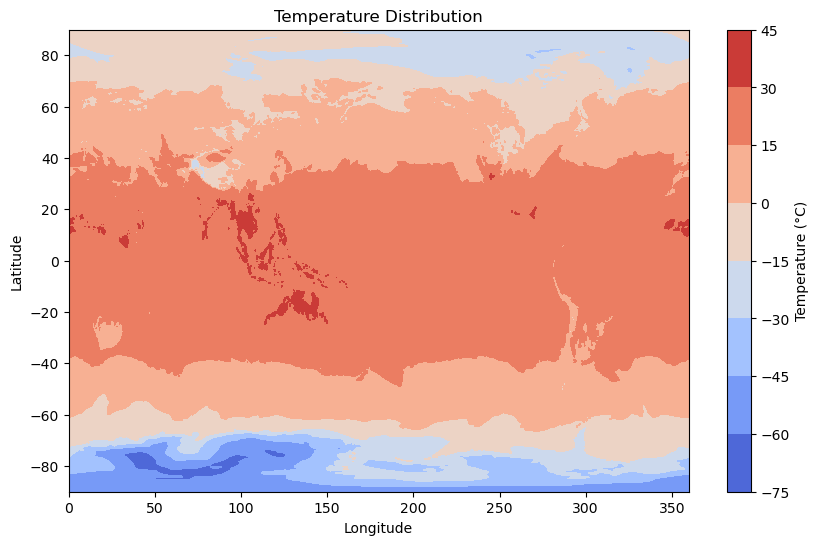

In [9]:
# Convert temperatures from Kelvin to Celsius if needed
temperature_celsius = temperature[:] - 273.15

# Select a specific time slice (if 'valid_time' is a time dimension)
temperature_slice = temperature_celsius[
    0, :, :
]  # Selecting the first time index for simplicity

# Create a plot
plt.figure(figsize=(10, 6))
plt.contourf(longitude[:], latitude[:], temperature_slice, cmap="coolwarm")
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [10]:
def get_nearest_temperature_api(latitude, longitude, file_path):
    ds = Dataset(file_path, "r")
    latitudes = ds.variables['latitude'][:]
    longitudes = ds.variables['longitude'][:]
    temperatures = ds.variables['t2m'][0, :, :]
    distances = np.sqrt((latitudes[:, np.newaxis] - latitude) ** 2 + (longitudes - longitude) ** 2)
    idx_min = np.unravel_index(np.argmin(distances), distances.shape)
    nearest_temperature = temperatures[idx_min]
    ds.close()
    return nearest_temperature


path_temperature_api = "./download.nc"
latitude = 45.0
longitude = -75.0
temperature = get_nearest_temperature_api(latitude, longitude, path_temperature_api)
print(f"Nearest temperature: {temperature}")

Nearest temperature: 286.9781494140625


In [11]:
def test_get_nearest_temperature_api(latitude, longitude, expected_temperature):
    tolerance = 1e-4
    actual_temperature = get_nearest_temperature_api(latitude, longitude, path_temperature_api)

    if abs(actual_temperature - expected_temperature) <= tolerance:
        print("Barbara's code works!")
    else:
        print("do something!")


In [12]:
latitude = 9.0
longitude = 34
expected_temperature = 295.552368
test_get_nearest_temperature_api(latitude, longitude, expected_temperature)

latitude = -9.5
longitude = 38.50
expected_temperature = 300.204712
test_get_nearest_temperature_api(latitude, longitude, expected_temperature)

latitude = 24.45118	
longitude = 54.39696
expected_temperature = 305.109009
test_get_nearest_temperature_api(latitude, longitude, expected_temperature)

do something!
do something!
do something!


In [13]:
# test data from perfect merged scenario
test_data = {
    "City": ["Addis Ababa", "Lindi", "Tunis"],
    "Latitude": [9.0, -9.5, 34.0],
    "Longitude": [38.75, 38.50, 9.00],
    "Temperature": [288.161743, 300.204712, 305.109009],
}
test_data = pd.DataFrame(test_data)

In [14]:
merged_df = pd.merge(
    countries_df, eui_df, left_on=0, right_on="Geonames ID", how="inner"
)
merged_df.rename(columns={4: "latitud", 5: "longitud"}, inplace=True)

In [15]:
merged_df['Region'] = merged_df[17].str.split('/').str[0]

region_mapping = {
    'Asia': 'Asia & Oceania',
    'Africa': 'Africa',
    'Europe': 'Europe',
    'America': 'America',
    'Pacific': 'Asia & Oceania',
    'Indian': 'Asia & Oceania',
    'Australia': 'Asia & Oceania',
    'Atlantic': 'Atlantic'
}

merged_df['Region Grouped'] = merged_df['Region'].map(region_mapping)

merged_df.loc[merged_df[1] == 'Praia', 'Region Grouped'] = 'Africa'

In [16]:
merged_df['Region Grouped'].value_counts()

Asia & Oceania    187
Africa            123
Europe             88
America            84
Name: Region Grouped, dtype: int64

In [17]:
merged_df["temperature"] = merged_df.apply(
    lambda row: get_nearest_temperature_api(row["latitud"], row["longitud"], path_temperature_api),
    axis=1,
)
merged_df

,0,1,2,3,latitud,longitud,6,7,8,9,...,17,18,City,Geonames ID,Country,Residential EUI (kWh/m2/year),Non-residential EUI (kWh/m2/year),Region,Region Grouped,temperature
0,292968,Abu Dhabi,Abu Dhabi,"A-pu-that-pi,AEbu Saby,AUH,Aboe Dhabi,Abou Dab...",24.45118,54.39696,P,PPLC,AE,NaN,...,Asia/Dubai,2024-03-27,Abu Dhabi,292968,United Arab Emirates,128.447899,226.725457,Asia,Asia & Oceania,295.552368
1,1138958,Kabul,Kabul,"Cabool,Caboul,Cabul,Cabura,Cabúl,Caubul,KBL,Ka...",34.52813,69.17233,P,PPLC,AF,NaN,...,Asia/Kabul,2024-09-05,Kabul,1138958,Afghanistan,213.167026,144.395840,Asia,Asia & Oceania,280.458618
2,3183875,Tirana,Tirana,"TIA,Terana,Theranda,Tiorana,Tiorána,Tiran,Tira...",41.32750,19.81889,P,PPLC,AL,NaN,...,Europe/Tirane,2023-01-01,Tirana,3183875,Albania,133.717672,101.873579,Europe,Europe,282.849243
3,616052,Yerevan,Yerevan,"Ayrivan,Djerevan,EVN,Eireavan,Eireaván,Ereban,...",40.18111,44.51361,P,PPLC,AM,NaN,...,Asia/Yerevan,2023-11-13,Yerevan,616052,Armenia,198.865302,132.124738,Asia,Asia & Oceania,278.196899
4,2240449,Luanda,Luanda,"LAD,Loanda,Louanda,Louanta,Luand,Luanda,Luanda...",-8.83682,13.23432,P,PPLC,AO,NaN,...,Africa/Luanda,2024-03-26,Luanda,2240449,Angola,65.343750,104.311100,Africa,Africa,298.646118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,1018725,Bloemfontein,Bloemfontein,"BFN,Bloemfontein,Blumfantehjn,Blumfonteina,Blu...",-29.12107,26.21400,P,PPLA,ZA,NaN,...,Africa/Johannesburg,2022-08-16,Bloemfontein,1018725,South Africa,78.735991,106.046441,Africa,Africa,278.437134
478,3369157,Cape Town,Cape Town,"Altepetl In Cabo,Ar Chab,CPT,Cape Toun,Cape To...",-33.92584,18.42322,P,PPLA,ZA,NaN,...,Africa/Johannesburg,2024-03-27,Cape Town,3369157,South Africa,71.455819,104.301427,Africa,Africa,286.126587
479,909137,Lusaka,Lusaka,"LUN,Lousaka,Louzaka,Lusaca,Lusak,Lusaka,Lusako...",-15.40669,28.28713,P,PPLC,ZM,NaN,...,Africa/Lusaka,2019-09-05,Lusaka,909137,Zambia,75.533405,105.500787,Africa,Africa,290.786743
480,890299,Harare,Harare,"Arare,Charare,HRE,Harare,Hararensis Urbs,Harar...",-17.82772,31.05337,P,PPLC,ZW,NaN,...,Africa/Harare,2019-09-05,Harare,890299,Zimbabwe,69.613147,102.108799,Africa,Africa,288.980103


In [18]:
def caculate_comfort_index(temperature):
    celsius = temperature - 273.15
    comfort_index = abs(celsius - 23)
    return comfort_index

merged_df["comfort_index"] = merged_df["temperature"].apply(caculate_comfort_index)


## Models

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
# Model 1: KNN
X_knn = merged_df[["latitud", "longitud"]]
y_knn = merged_df["Residential EUI (kWh/m2/year)"]

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, random_state=42
)

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)

y_pred_knn = knn_model.predict(X_test_knn)

 
metrics_knn = {
    'Model': 'KNN',
    'MSE': mean_squared_error(y_test_knn, y_pred_knn),
    'R²': r2_score(y_test_knn, y_pred_knn),
    'MAE': mean_absolute_error(y_test_knn, y_pred_knn),
    'RMSE': np.sqrt(mean_squared_error(y_test_knn, y_pred_knn)),
    'MAPE': mean_absolute_percentage_error(y_test_knn, y_pred_knn),
    'WAPE': np.sum(np.abs(y_test_knn - y_pred_knn)) / np.sum(np.abs(y_test_knn)) * 100
}
metrics_knn

{'Model': 'KNN',
 'MSE': 874.9873963222925,
 'R²': 0.7924616777333092,
 'MAE': 18.912354239896906,
 'RMSE': 29.58018587369411,
 'MAPE': 0.1752385502328791,
 'WAPE': 18.33904218396843}

In [49]:
# Linear Regression Model (Temperature)
X_linear = merged_df[["temperature"]]
y_linear = merged_df["Residential EUI (kWh/m2/year)"]

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

linear_model = LinearRegression()
linear_model.fit(X_train_linear, y_train_linear)

y_pred_linear = linear_model.predict(X_test_linear)

 
metrics_linear = {
    'Model': 'LR (Temperature)',
    'MSE': mean_squared_error(y_test_linear, y_pred_linear),
    'R²': r2_score(y_test_linear, y_pred_linear),
    'MAE': mean_absolute_error(y_test_linear, y_pred_linear),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_linear)),
    'MAPE': mean_absolute_percentage_error(y_test_linear, y_pred_linear),
    'WAPE': np.sum(np.abs(y_test_linear - y_pred_linear)) / np.sum(np.abs(y_test_linear)) * 100
}


metrics_linear

{'Model': 'LR (Temperature)',
 'MSE': 2426.1161478007466,
 'R²': 0.42454933973331166,
 'MAE': 37.60142164926869,
 'RMSE': 49.25562046914795,
 'MAPE': 0.4163708915010864,
 'WAPE': 36.461566289215256}

### Using comfortable temperature

In [50]:
# Linear Regression Model (Comfort Index)
X_linear = merged_df[["comfort_index"]]  # Independent variable
y_linear = merged_df["Residential EUI (kWh/m2/year)"]  # Dependent variable

# Split the dataset into training and testing sets
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

# Initialize the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_linear, y_train_linear)  # Fit the model to the training data

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test_linear)

# Store evaluation metrics
metrics_linear = {
    'Model': 'LR (Comfort Index)',
    'MSE': mean_squared_error(y_test_linear, y_pred_linear),
    'R²': r2_score(y_test_linear, y_pred_linear),
    'MAE': mean_absolute_error(y_test_linear, y_pred_linear),
    'RMSE': np.sqrt(mean_squared_error(y_test_linear, y_pred_linear)),
    'MAPE': mean_absolute_percentage_error(y_test_linear, y_pred_linear),
    'WAPE': np.sum(np.abs(y_test_linear - y_pred_linear)) / np.sum(np.abs(y_test_linear)) * 100
}

metrics_linear

{'Model': 'LR (Comfort Index)',
 'MSE': 2828.917615447685,
 'R²': 0.32900883120327307,
 'MAE': 43.03776639398555,
 'RMSE': 53.18757012167114,
 'MAPE': 0.5117609637403014,
 'WAPE': 41.73311283150871}

## Using continents

In [51]:
continents = ['Asia & Oceania', 'Africa', 'Europe', 'America']
metrics = []

for continent in continents:
    test_data = merged_df[merged_df['Region Grouped'] == continent]
    train_data = merged_df[merged_df['Region Grouped'] != continent]
    
    X_train_knn = train_data[["latitud", "longitud"]]
    y_train_knn = train_data["Residential EUI (kWh/m2/year)"]
    
    X_test_knn = test_data[["latitud", "longitud"]]
    y_test_knn = test_data["Residential EUI (kWh/m2/year)"]
    
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train_knn, y_train_knn)
    
    y_pred_knn = knn_model.predict(X_test_knn)
    
    mse_knn = mean_squared_error(y_test_knn, y_pred_knn)
    r2_knn = r2_score(y_test_knn, y_pred_knn)
    mae_knn = mean_absolute_error(y_test_knn, y_pred_knn)
    rmse_knn = np.sqrt(mse_knn)
    mape_knn = mean_absolute_percentage_error(y_test_knn, y_pred_knn)
    wape_knn = np.sum(np.abs(y_test_knn - y_pred_knn)) / np.sum(np.abs(y_test_knn)) * 100
    
    metrics.append({
        'MSE': mse_knn,
        'R²': r2_knn,
        'MAE': mae_knn,
        'RMSE': rmse_knn,
        'MAPE': mape_knn,
        'WAPE': wape_knn
    })

average_metrics = pd.DataFrame(metrics).mean()

average_metrics

MSE     5764.178808
R²        -5.244109
MAE       52.230843
RMSE      69.597773
MAPE       0.420145
WAPE      44.117895
dtype: float64

In [47]:
results = []

# Model 1: KNN
results.append({
    'Model': 'KNN',
    'MSE': mse_knn,
    'R²': r2_knn,
    'MAE': mae_knn,
    'RMSE': rmse_knn,
    'MAPE': mape_knn,
    'WAPE': wape_knn
})

# Model 2: LR (for temperature)
results.append({
    'Model': 'LR (Temperature)',
    'MSE': mse_linear,
    'R²': r2_linear,
    'MAE': mae_linear,
    'RMSE': rmse_linear,
    'MAPE': mape_linear,
    'WAPE': wape_linear
})

# Model 3: LR (for comfort index) using the stored metrics
results.append({
    'Model': 'LR (Comfort Index)',
    'MSE': metrics_linear['MSE'],
    'R²': metrics_linear['R²'],
    'MAE': metrics_linear['MAE'],
    'RMSE': metrics_linear['RMSE'],
    'MAPE': metrics_linear['MAPE'],
    'WAPE': metrics_linear['WAPE']
})

# Model 4: KNN (cross-validated by continents)
results.append({
    'Model': 'KNN (Continents)',
    'MSE': average_metrics['MSE'],
    'R²': average_metrics['R²'],
    'MAE': average_metrics['MAE'],
    'RMSE': average_metrics['RMSE'],
    'MAPE': average_metrics['MAPE'],
    'WAPE': average_metrics['WAPE']
})



summary_df = pd.DataFrame(results)

summary_df


,Model,MSE,R²,MAE,RMSE,MAPE,WAPE
0,KNN,2131.929956,-0.569097,29.018164,46.172827,0.229176,30.377233
1,LR (Temperature),1610.754251,-0.185513,33.333276,40.134203,0.344024,34.894443
2,LR (Comfort Index),2828.917615,0.329009,43.037766,53.187570,0.511761,41.733113
3,KNN (Continents),5764.178808,-5.244109,52.230843,69.597773,0.420145,44.117895
4,"LR (Temperature, Continents)",5764.178808,-5.244109,52.230843,69.597773,0.420145,44.117895
5,"LR (Comfort Index, Continents)",5764.178808,-5.244109,52.230843,69.597773,0.420145,44.117895
